<p style="color: white; font-size: 3rem; font-weight: bold; background-color: lightcoral; text-align: center">
    PREPARACIÓN Y ANÁLISIS DE DATOS 
</p>

<p style="color: lightcoral; font-size: 2.5rem">
    1. Creación del ambiente inicial de trabajo
</p>

Se realizan las importaciones necesarias para este paso y se cargan los datos. Imprimiremos también en pantalla información básica sobre el dataset.

In [42]:
# Importación de bibliotecas necesarias
import pandas as pd
import numpy as np

# Cargar los datos
df = pd.read_csv(r'../data/1_interim/database_rg.csv')

# Mostrar información básica del DataFrame
print("Primeras 5 filas del DataFrame:")
print(df.head())
print("\nInformación del DataFrame:")
print(df.info())

Primeras 5 filas del DataFrame:
        Fecha  Total  HechosSimples HechosMortales Victimas  \
0  01/01/2009    157            154              0        0   
1  02/01/2009    178            176              0        0   
2  03/01/2009    267            250              2        2   
3  04/01/2009    217            202              1        1   
4  05/01/2009    233            225              0        0   

   HechosConLesiones  Lesionados  HechosUrbanos HechosRurales  
0                  3           3            149             8  
1                  2           2            166            12  
2                 15          15            259             8  
3                 14          13            209             8  
4                  8          10            224             9  

Información del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176 entries, 0 to 175
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --

Se puede observar que existen variables categóricas en campos que deberían ser solo numéricos. Cuando tenemos campos que deberían ser numéricos pero son detectados como 'object' (string), hay varias formas de investigar los valores problemáticos. 

**unique():**

Rápido vistazo a todos los valores posibles. Útil para detectar errores obvios como espacios extras, símbolos extraños

**to_numeric() con manejo de errores:**

Identifica exactamente qué filas tienen problemas. Útil para localizar dónde están los errores.

**value_counts():**

Muestra la frecuencia de cada valor. Útil para detectar valores atípicos o poco frecuentes

**Verificación de tipos específicos:**

Muestra el tipo exacto de cada valor. Útil para detectar inconsistencias en los tipos de datos

---

Siempre comenzaremos con *unique()* para tenr una visión general. 

In [43]:
columnas_object = df.select_dtypes(include=['object']).columns
for columna in columnas_object:
    if columna=="Fecha":
        continue
    else:
        print(f"\n{columna}:")
        print(df[columna].unique())


HechosMortales:
['0' '2' '1' '3' '-']

Victimas:
['0' '2' '1' '6' '3' '9' '-' '4']

HechosRurales:
['8' '12' '9' '6' '4' '1' '3' '0' '5' '14' '10' '7' '13' '21' '22' '11'
 '15' '-' '2']


Vemos entonces, que los campos que deberían ser de tipo numéricos son de tipo caracter a causa de algunos datos con valor "-". En el caso de las fechas, todas tienen el valor correcto, pero hay que convertirlas de "Object" a "Date".

En el caso de que la variable numérica sea de tipo continua, no nos serviría de mucho, ya que alargaría demasiado la salida por pantalla, por lo que utilizaríamos *"to_numeric()"*

In [44]:
def encontrar_no_numericos(df, columna):
    # Intentar convertir a numérico y ver qué filas fallan
    errores = pd.to_numeric(df[columna], errors='coerce').isna()
    if errores.any():
        print(f"\nValores no numéricos en {columna}:")
        print(df.loc[errores, columna].unique())
        print(f"Filas con valores no numéricos:")
        print(df[errores].index.tolist())
    return errores.sum()

print("\nBúsqueda de valores no numéricos:")
for columna in ['HechosMortales', 'Victimas', 'HechosRurales']:
    n_errores = encontrar_no_numericos(df, columna)
    print(f"Total de valores no numéricos en {columna}: {n_errores}")



Búsqueda de valores no numéricos:

Valores no numéricos en HechosMortales:
['-']
Filas con valores no numéricos:
[60, 64, 65, 67, 70, 71, 73, 74, 76, 77, 78, 79, 80, 81, 82, 83, 85, 88, 89, 90, 95, 98, 99, 100, 101, 102, 103, 104, 105, 106, 110, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 125, 127, 129, 130, 131, 144, 145, 146, 147, 148, 149, 150, 152, 154, 155, 157, 158, 161, 162, 163, 164, 165, 166, 167, 169, 170, 171, 172, 173, 174]
Total de valores no numéricos en HechosMortales: 72

Valores no numéricos en Victimas:
['-']
Filas con valores no numéricos:
[60, 63, 64, 65, 67, 70, 71, 73, 74, 76, 77, 78, 79, 80, 81, 83, 85, 88, 89, 90, 95, 98, 99, 100, 101, 102, 103, 104, 105, 106, 110, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 125, 127, 129, 130, 131, 144, 145, 146, 147, 148, 149, 150, 152, 154, 155, 157, 158, 161, 162, 163, 164, 165, 166, 167, 169, 170, 171, 172, 173, 174]
Total de valores no numéricos en Victimas: 72

Valores no numéricos en HechosRurales:

Esto nos deja un panorama mas claro de que el unico valor que no nos deja convertir los datos a tipo numérico son "-". También nos indica en cuantas filas (y cuales) existe este caracter.

---

<p style="color: lightcoral; font-size: 2.5rem">
    2. Imputación de valores
</p>

En este caso, no sería correcto usar técnicas de imputación como media o mediana, ya que el "-" no representa datos faltantes sino ausencia de eventos. Lo más apropiado sería reemplazar estos "-" por 0.

In [45]:
# 1. Convertir los '-' a 0 y transformar a numérico
columnas_a_limpiar = ['HechosMortales', 'Victimas', 'HechosRurales']
df[columnas_a_limpiar] = df[columnas_a_limpiar].replace('-', 0)

# Convertir a tipo numérico
for columna in columnas_a_limpiar:
    df[columna] = pd.to_numeric(df[columna])


Convertimos los campos de fecha actuamente de tipo Object a tipo Date y mostramos los resultados en pantalla.

In [46]:
# Convertir la columna Fecha a datetime
df['Fecha'] = pd.to_datetime(df['Fecha'], format='%d/%m/%Y')

# Verificar los cambios
print("Tipos de datos después de la limpieza:")
print(df.info())

Tipos de datos después de la limpieza:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176 entries, 0 to 175
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Fecha              176 non-null    datetime64[ns]
 1   Total              176 non-null    int64         
 2   HechosSimples      176 non-null    int64         
 3   HechosMortales     176 non-null    int64         
 4   Victimas           176 non-null    int64         
 5   HechosConLesiones  176 non-null    int64         
 6   Lesionados         176 non-null    int64         
 7   HechosUrbanos      176 non-null    int64         
 8   HechosRurales      176 non-null    int64         
dtypes: datetime64[ns](1), int64(8)
memory usage: 12.5 KB
None


Una vez teniéndo el dataframe sin errores en los tipos de datos, podemos comenzar por:

<p style="color: lightcoral; font-size: 2.5rem">
3. Análisis Exploratorio de Datos (EDA)
</p>

Para ello importaremos las bibliotecas de visualización y reaizamos unas estadísticas descriptivas básicas

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
print(df.describe())

                               Fecha       Total  HechosSimples  \
count                            176  176.000000     176.000000   
mean   2015-11-09 16:54:32.727272704  160.329545     140.937500   
min              2009-01-01 00:00:00    9.000000       6.000000   
25%              2012-01-08 18:00:00   58.000000      40.000000   
50%              2016-01-04 12:00:00  121.000000      97.000000   
75%              2019-04-10 12:00:00  241.000000     226.250000   
max              2023-01-08 00:00:00  457.000000     445.000000   
std                              NaN  114.603039     115.239584   

       HechosMortales    Victimas  HechosConLesiones  Lesionados  \
count      176.000000  176.000000         176.000000  176.000000   
mean         0.380682    0.465909          19.011364   27.988636   
min          0.000000    0.000000           2.000000    2.000000   
25%          0.000000    0.000000          14.000000   19.000000   
50%          0.000000    0.000000          18.000000   2

Primero, veamos una evolución temporal de los diferentes tipos de accidentes

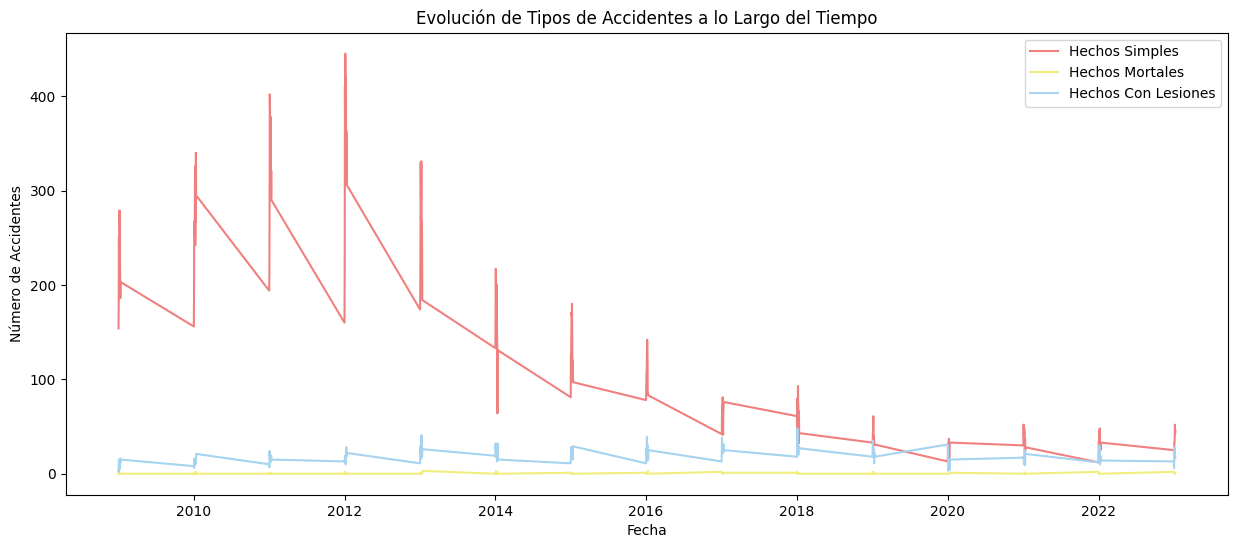

In [48]:
plt.figure(figsize=(15, 6))
plt.plot(df['Fecha'], df['HechosSimples'], label='Hechos Simples', color='#F08080')
plt.plot(df['Fecha'], df['HechosMortales'], label='Hechos Mortales', color='#F0EE7F')
plt.plot(df['Fecha'], df['HechosConLesiones'], label='Hechos Con Lesiones', color='#A5D3F0')
plt.title('Evolución de Tipos de Accidentes a lo Largo del Tiempo')
plt.xlabel('Fecha')
plt.ylabel('Número de Accidentes')
plt.legend()
plt.show()

Veremos también la distribución de los accidentes con un gráfico de tortas

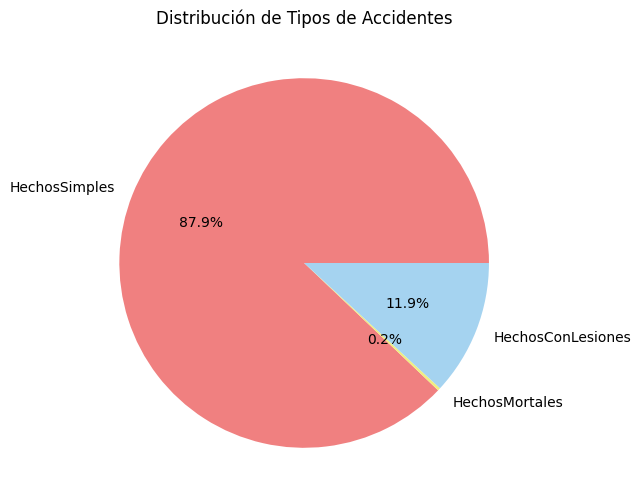

In [49]:
df_tipos = df[['HechosSimples', 'HechosMortales', 'HechosConLesiones']].sum()
plt.figure(figsize=(8, 6))
plt.pie(df_tipos, labels=df_tipos.index, autopct='%1.1f%%', colors=('#F08080', '#F0EE7F', '#A5D3F0'))
plt.title('Distribución de Tipos de Accidentes')
plt.show()

Comparación entre accidentes urbanos y rurales

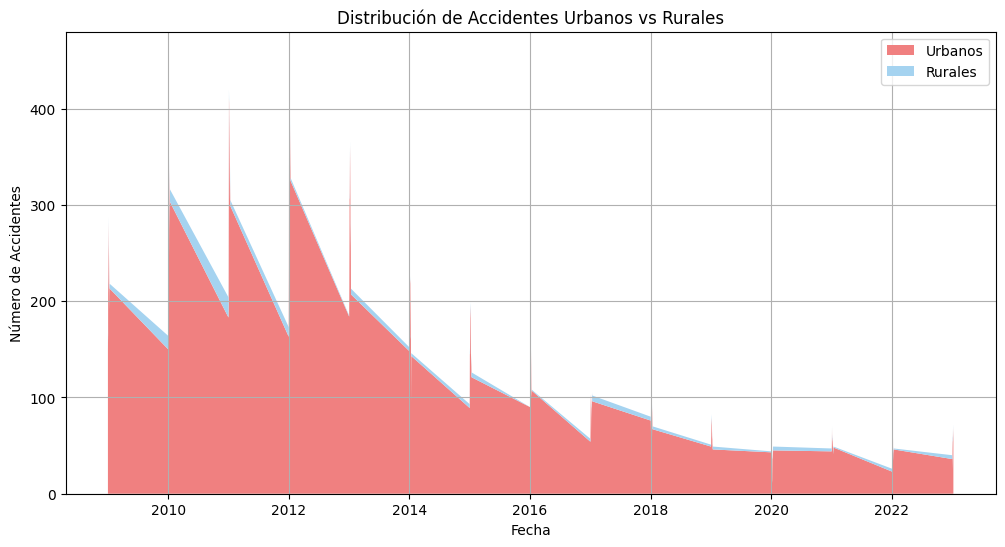

In [50]:
plt.figure(figsize=(12, 6))
plt.stackplot(df['Fecha'], [df['HechosUrbanos'], df['HechosRurales']], 
              labels=['Urbanos', 'Rurales'], colors=('#F08080', '#A5D3F0'))
plt.title('Distribución de Accidentes Urbanos vs Rurales')
plt.xlabel('Fecha')
plt.ylabel('Número de Accidentes')
plt.legend()
plt.grid(True)
plt.show()

Veamos si encontramos una correlación entre variables, con principal interés en los hechos rurales/ urbanos, para ayudarnos a predecir los acontecimientos mas adelante.

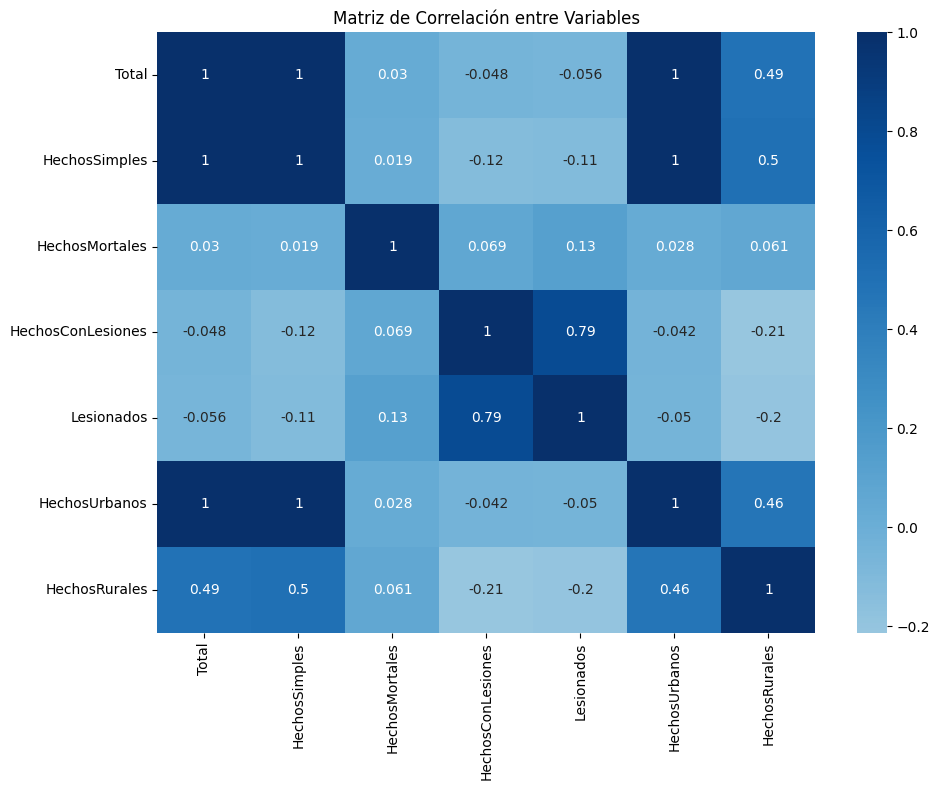

In [51]:
matriz_correlacion = df[['Total', 'HechosSimples', 'HechosMortales', 
                        'HechosConLesiones', 'Lesionados', 
                        'HechosUrbanos', 'HechosRurales']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(matriz_correlacion, annot=True, cmap='Blues', center=0)
plt.title('Matriz de Correlación entre Variables')
plt.tight_layout()
plt.show()

Vemos una clara relación fuerte entre los hechos con lesiones y los lesionados, por la la naturaleza de los datos. Observamos una relación muy fuerte entre total y hechos simples, por lo que podemos decir que la mayoría de hechos son de tipo simple; esto lo podemos corroborar con el diagrama de torta anterior. La correlación entre total y hechos urbanos sugiere que la mayoría de los accidentes ocurren en zonas urbanas.

Observamos las relaciones fuertes:

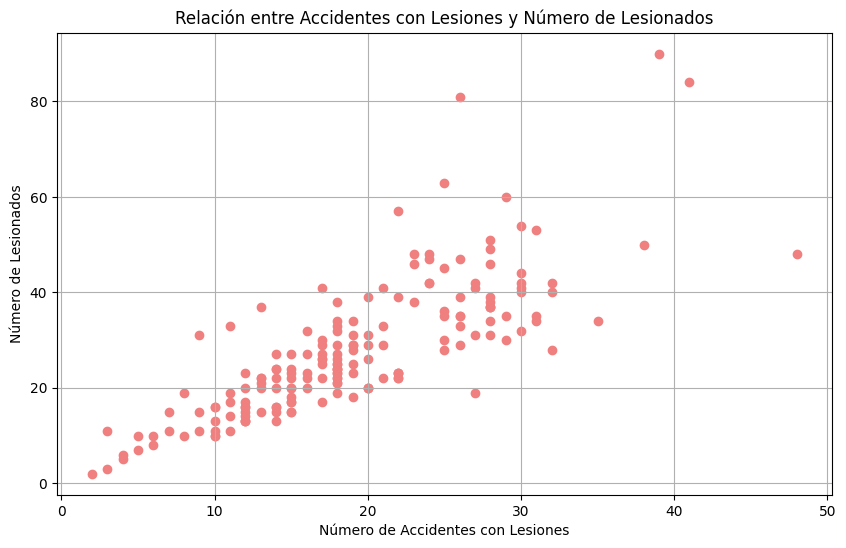

In [52]:
plt.figure(figsize=(10, 6))
plt.scatter(df['HechosConLesiones'], df['Lesionados'], color=('lightcoral'))
plt.title('Relación entre Accidentes con Lesiones y Número de Lesionados')
plt.xlabel('Número de Accidentes con Lesiones')
plt.ylabel('Número de Lesionados')
plt.grid(True)
plt.show()

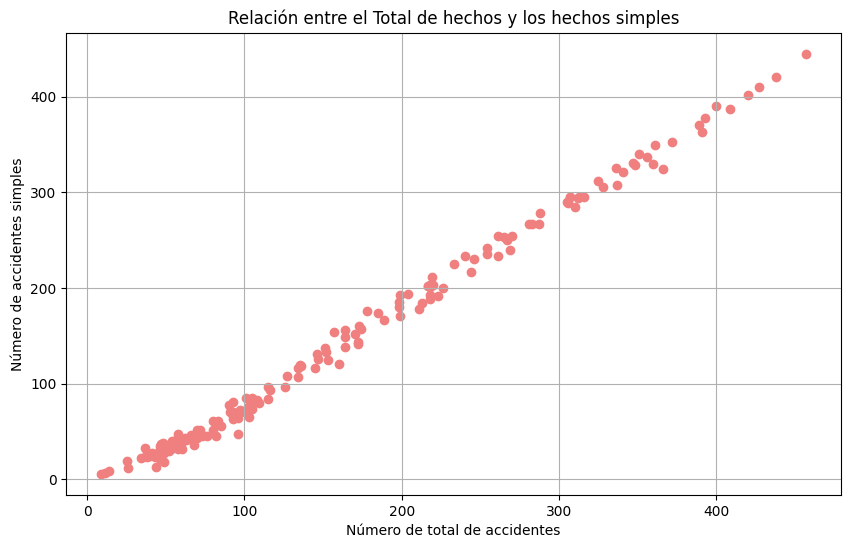

In [53]:
plt.figure(figsize=(10, 6))
plt.scatter(df['Total'], df['HechosSimples'], color=('lightcoral'))
plt.title('Relación entre el Total de hechos y los hechos simples')
plt.xlabel('Número de total de accidentes')
plt.ylabel('Número de accidentes simples')
plt.grid(True)
plt.show()

Correlaciones moderadas:
HechosRurales con Total (0.49), HechosSimples (0.5) y HechosUrbanos (0.46): Indica una relación moderada positiva.

Este análisis sugiere que los accidentes son predominantemente urbanos y la mayoría son hechos simples. Los hechos mortales parecen ocurrir de manera independiente a otros tipos de accidentes

---

Es importante analizar los outliers para el modelo de aprendizaje automático, por lo que realizaremos algunas visualizaciones para predecir que hacer con los mismos, por lo que debemos considerar si:

- ¿Son errores de datos?

- ¿Son eventos excepcionales pero reales (como accidentes masivos)?

- ¿Siguen algún patrón temporal (ej: más accidentes en ciertos períodos)?

## Boxplot.
Realizamos un boxplot para visualizar outliers en todas las variables.

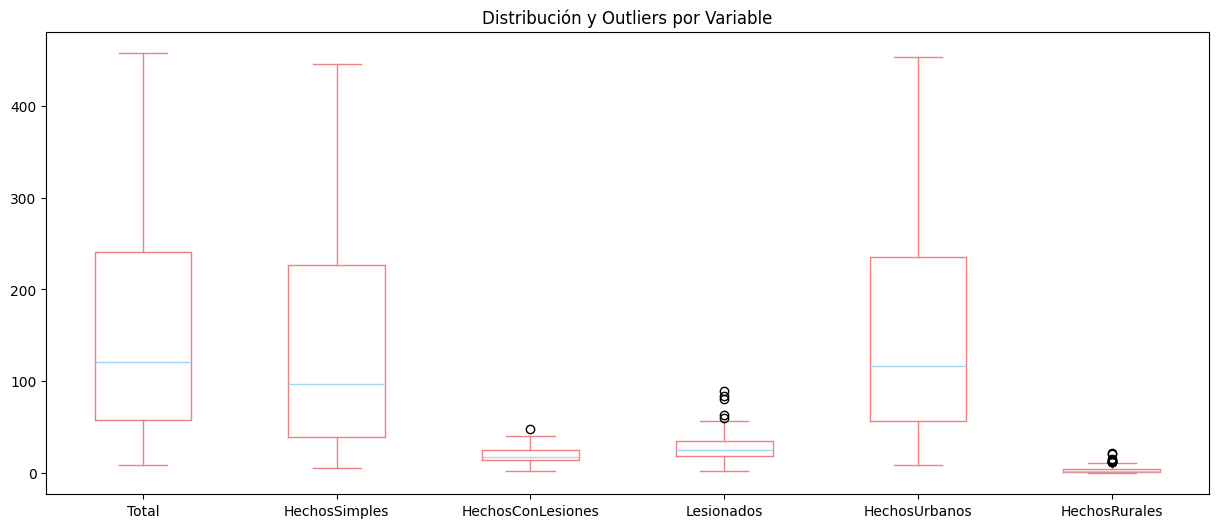

In [54]:
plt.figure(figsize=(15, 6))
df.boxplot(column=['Total', 'HechosSimples', 'HechosConLesiones', 'Lesionados', 'HechosUrbanos', 'HechosRurales'],
           boxprops=dict(color='lightcoral'),
           whiskerprops=dict(color='lightcoral'),
           capprops=dict(color='lightcoral'),
           flierprops=dict(color='lightcoral'),
           medianprops=dict(color='#A5D3F0')
            )
plt.title('Distribución y Outliers por Variable')
plt.grid(False)
plt.show()

Análisis estadistico de outliers:

In [55]:
def detectar_outliers(df, columna):
    Q1 = df[columna].quantile(0.25)
    Q3 = df[columna].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    
    outliers = df[(df[columna] < limite_inferior) | (df[columna] > limite_superior)]
    
    print(f"\nOutliers en {columna}:")
    print(f"Número de outliers: {len(outliers)}")
    if len(outliers) > 0:
        print("Valores outliers:")
        print(outliers[['Fecha', columna]].sort_values(by=columna, ascending=False))
        print(f"Límite inferior: {limite_inferior:.2f}")
        print(f"Límite superior: {limite_superior:.2f}")
    return outliers

variables = ['Total', 'HechosSimples', 'HechosConLesiones', 'Lesionados', 'HechosUrbanos', 'HechosRurales']

for var in variables:
    detectar_outliers(df, var)


Outliers en Total:
Número de outliers: 0

Outliers en HechosSimples:
Número de outliers: 0

Outliers en HechosConLesiones:
Número de outliers: 1
Valores outliers:
         Fecha  HechosConLesiones
110 2018-01-03                 48
Límite inferior: -2.50
Límite superior: 41.50

Outliers en Lesionados:
Número de outliers: 5
Valores outliers:
         Fecha  Lesionados
88  2016-01-05          90
55  2013-01-08          84
124 2019-01-05          81
107 2017-01-12          63
83  2015-01-12          60
Límite inferior: -5.00
Límite superior: 59.00

Outliers en HechosUrbanos:
Número de outliers: 0

Outliers en HechosRurales:
Número de outliers: 9
Valores outliers:
        Fecha  HechosRurales
25 2011-01-02             22
24 2011-01-01             21
34 2011-01-11             15
12 2010-01-01             14
23 2010-01-12             13
1  2009-01-02             12
13 2010-01-02             12
14 2010-01-03             12
37 2012-01-02             12
Límite inferior: -5.00
Límite superior: 1

Según las métricas descriptivas, los outliers parecen ser eventos reales, mas viendo que hay una concentración temporal de outliers en ciertos periodos.

Puedo mantener los outliers porque podrían representar patrones importantes (Ej: Mas accidentes en verano), pero dada la naturaleza del modelo, voy a tratarlo con una técnica de modelado robusta como randomforest, para adecuar los valores a algo mas consistente, manteniendo la veracidad en los datos.

---

<p style="color: lightcoral; font-size: 2.5rem">
    4. Manejo de Outliers: KNN Vecinos Cercanos
</p>

Comenzamos importando las bibliotecas necesarias e identificando los outliers (con método IQR).

In [59]:
from sklearn.model_selection import cross_val_score
from sklearn.impute import KNNImputer

# Identificamos los outliers para todas las columnas
columnas_analizar = ['HechosConLesiones', 'Lesionados', 'HechosRurales']
outliers_info = {}

for columna in columnas_analizar:
    # Calculamos Q1, Q3 e IQR
    Q1 = df[columna].quantile(0.25)
    Q3 = df[columna].quantile(0.75)
    IQR = Q3 - Q1
    
    # Calculamos los límites
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    
    # Identificamos los índices de outliers
    indices = df[(df[columna] < limite_inferior) | 
                 (df[columna] > limite_superior)].index
    
    # Guardamos la información
    outliers_info[columna] = {
        'Q1': Q1,
        'Q3': Q3,
        'IQR': IQR,
        'limite_inferior': limite_inferior,
        'limite_superior': limite_superior,
        'indices': indices,
        'n_outliers': len(indices)
    }

# Mostramos un resumen
for columna, info in outliers_info.items():
    print(f"\nOutliers en {columna}:")
    print(f"Número de outliers: {info['n_outliers']}")
    print(f"Límites: [{info['limite_inferior']:.2f}, {info['limite_superior']:.2f}]")


Outliers en HechosConLesiones:
Número de outliers: 1
Límites: [-2.50, 41.50]

Outliers en Lesionados:
Número de outliers: 5
Límites: [-5.00, 59.00]

Outliers en HechosRurales:
Número de outliers: 9
Límites: [-5.00, 11.00]


Una vez identificados los outliers, pasaremos a elegir un k valor. Por lo general es la raiz cuadrada del numero de registros; pero evaluaremos varios valores para probar y elegir el mejor.

In [60]:
# 1. Primero, definimos un rango de valores k a probar
# Como regla general, k debe ser impar para evitar empates
n_muestras = len(df)
k_sugerido = int(np.sqrt(n_muestras))
if k_sugerido % 2 == 0:  # Si es par, lo hacemos impar
    k_sugerido += 1

print(f"Número de muestras: {n_muestras}")
print(f"K sugerido por regla general: {k_sugerido}")

# Creamos un rango de valores k a probar alrededor del k sugerido
valores_k = np.arange(3, k_sugerido + 4, 2)  # valores impares
print(f"Valores de k a probar: {valores_k}")

Número de muestras: 176
K sugerido por regla general: 13
Valores de k a probar: [ 3  5  7  9 11 13 15]


Calculamos el error para cada valor de K y cada columna:

In [61]:
# 2. Función para calcular distancias
def calcular_error_k(df, columna, indices_outliers, k):
    errores = []
    
    for idx in indices_outliers:
        mes = df.loc[idx, 'Mes']
        año = df.loc[idx, 'Año']
        
        # Calculamos distancias solo con no-outliers
        distancias = []
        for idx_normal in df.index:
            if idx_normal not in indices_outliers:
                mes_comp = df.loc[idx_normal, 'Mes']
                año_comp = df.loc[idx_normal, 'Año']
                
                # Distancia euclidiana normalizada
                dist_mes = (mes - mes_comp) / 12  # Normalizado por máximo mes
                dist_año = (año - año_comp) / (df['Año'].max() - df['Año'].min())
                distancia = np.sqrt(dist_mes**2 + dist_año**2)
                
                distancias.append((idx_normal, distancia))
        
        # K vecinos más cercanos
        distancias.sort(key=lambda x: x[1])
        vecinos = distancias[:k]
        
        # Valor predicho
        valores_vecinos = [df.loc[i, columna] for i, _ in vecinos]
        valor_predicho = np.mean(valores_vecinos)
        
        # Error
        error = abs(df.loc[idx, columna] - valor_predicho)
        errores.append(error)
    
    return np.mean(errores)

In [62]:
# 3. Calculamos el error para cada k y cada columna
resultados_k = {}

for columna in columnas_analizar:
    errores_k = []
    indices_outliers = outliers_info[columna]['indices']
    
    for k in valores_k:
        error = calcular_error_k(df, columna, indices_outliers, k)
        errores_k.append(error)
    
    resultados_k[columna] = errores_k

Visualizamos los valores obtenidos:

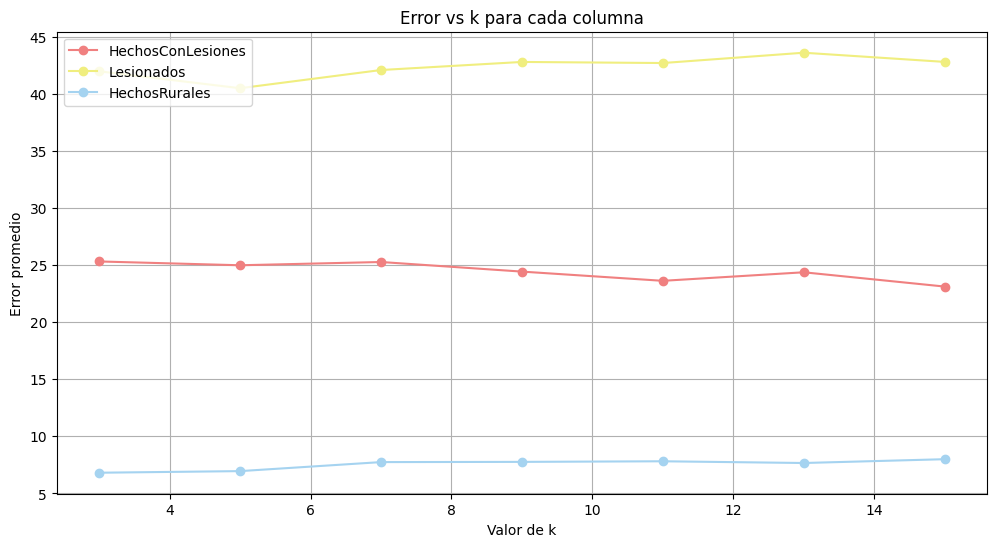

In [70]:
plt.figure(figsize=(12, 6))

colores = ['#F08080', '#F0EE7F', '#A5D3F0']

for i, (columna, errores) in enumerate(resultados_k.items()):
    plt.plot(valores_k, errores, 'o-', label=columna, color=colores[i % len(colores)])

plt.xlabel('Valor de k')
plt.ylabel('Error promedio')
plt.title('Error vs k para cada columna')
plt.legend()
plt.grid(True)
plt.legend(loc='upper left')
plt.show()


Podemos observar gráficamente el mejor K para cada columna, también lo podemos hacer de forma descriptiva:

In [71]:
mejores_k = {}

for columna, errores in resultados_k.items():
    mejor_k = valores_k[np.argmin(errores)]
    mejores_k[columna] = {
        'k': mejor_k,
        'error': min(errores)
    }
    
    print(f"\nMejor k para {columna}:")
    print(f"k = {mejor_k}")
    print(f"Error promedio = {min(errores):.2f}")


Mejor k para HechosConLesiones:
k = 15
Error promedio = 23.13

Mejor k para Lesionados:
k = 5
Error promedio = 40.52

Mejor k para HechosRurales:
k = 3
Error promedio = 6.81


Visualizamos la estabilidad de la predicción:

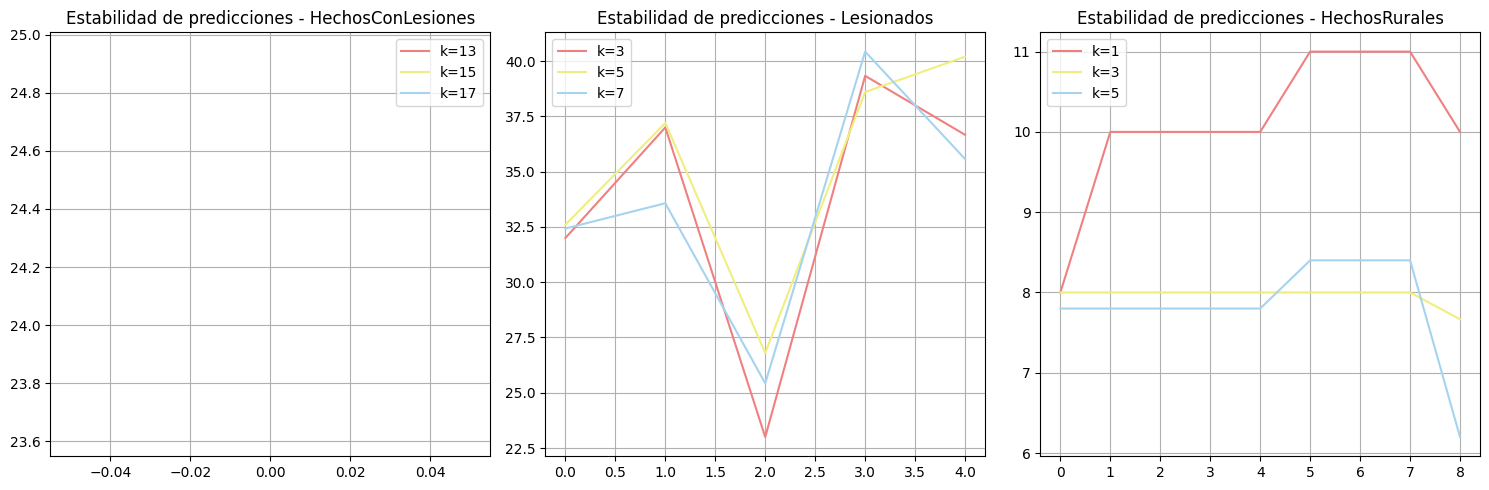

In [73]:
plt.figure(figsize=(15, 5))

colores = ['#F08080', '#F0EE7F', '#A5D3F0']  # Lista de colores

for i, columna in enumerate(columnas_analizar, 1):
    plt.subplot(1, 3, i)
    
    k_optimo = mejores_k[columna]['k']
    indices_outliers = outliers_info[columna]['indices']
    
    # Probamos k's cercanos al óptimo
    k_cercanos = [k_optimo - 2, k_optimo, k_optimo + 2]
    predicciones = []
    
    for k in k_cercanos:
        valores_predichos = []
        for idx in indices_outliers:
            mes = df.loc[idx, 'Mes']
            año = df.loc[idx, 'Año']
            
            distancias = []
            for idx_normal in df.index:
                if idx_normal not in indices_outliers:
                    mes_comp = df.loc[idx_normal, 'Mes']
                    año_comp = df.loc[idx_normal, 'Año']
                    dist_mes = (mes - mes_comp) / 12
                    dist_año = (año - año_comp) / (df['Año'].max() - df['Año'].min())
                    distancia = np.sqrt(dist_mes**2 + dist_año**2)
                    distancias.append((idx_normal, distancia))
            
            distancias.sort(key=lambda x: x[1])
            vecinos = distancias[:k]
            valores_vecinos = [df.loc[i, columna] for i, _ in vecinos]
            valores_predichos.append(np.mean(valores_vecinos))
        
        predicciones.append(valores_predichos)
    
    # Graficamos las predicciones con colores personalizados
    for j, pred in enumerate(predicciones):
        plt.plot(pred, label=f'k={k_cercanos[j]}', color=colores[j])
    
    plt.title(f'Estabilidad de predicciones - {columna}')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()


Por el gráfico mostrado, mejor dejamos un valor K menor para HechosConLesiones(13) y dejamos los otros valores como están. Procedemos a imputar y visualizar los resultados.

C:\Users\facun\AppData\Local\Temp\ipykernel_16456\3749932119.py:44: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '23.615384615384617' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_imputado.loc[idx, columna] = valor_imputado
C:\Users\facun\AppData\Local\Temp\ipykernel_16456\3749932119.py:44: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '32.6' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_imputado.loc[idx, columna] = valor_imputado
C:\Users\facun\AppData\Local\Temp\ipykernel_16456\3749932119.py:44: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '7.666666666666667' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_

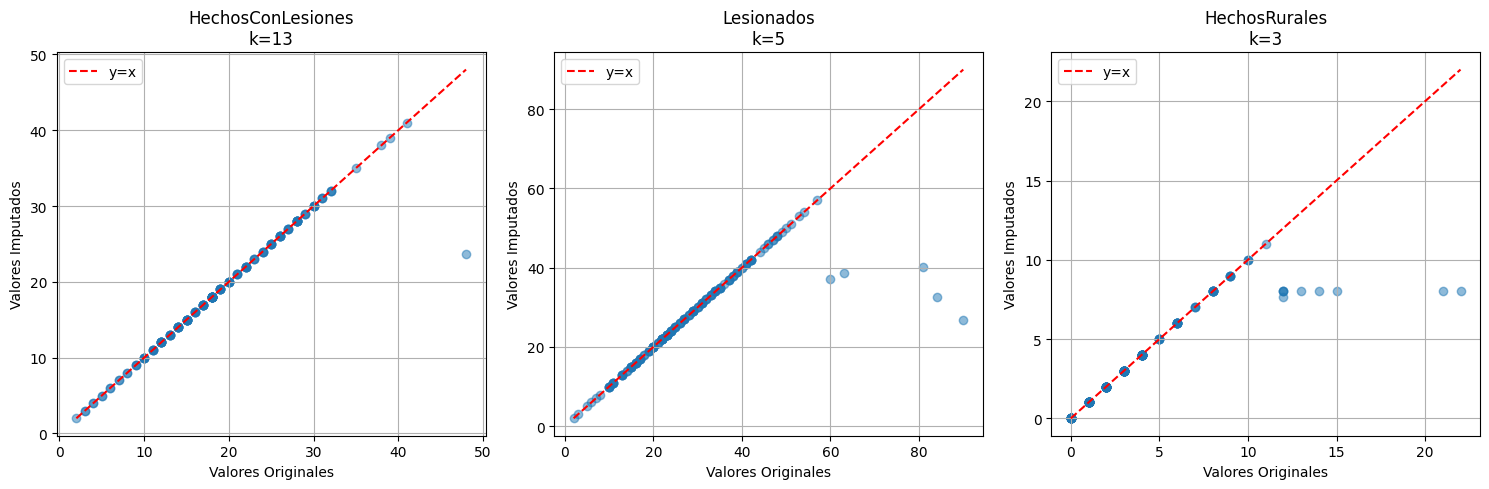


Ejemplos de imputación:

HechosConLesiones (k=13):
--------------------------------------------------
Índice 110:
Valor original: 48.00
Valor imputado: 23.62
Fecha: 2018-01-03 00:00:00
------------------------------

Lesionados (k=5):
--------------------------------------------------
Índice 55:
Valor original: 84.00
Valor imputado: 32.60
Fecha: 2013-01-08 00:00:00
------------------------------
Índice 83:
Valor original: 60.00
Valor imputado: 37.20
Fecha: 2015-01-12 00:00:00
------------------------------
Índice 88:
Valor original: 90.00
Valor imputado: 26.80
Fecha: 2016-01-05 00:00:00
------------------------------

HechosRurales (k=3):
--------------------------------------------------
Índice 1:
Valor original: 12.00
Valor imputado: 8.00
Fecha: 2009-01-02 00:00:00
------------------------------
Índice 12:
Valor original: 14.00
Valor imputado: 8.00
Fecha: 2010-01-01 00:00:00
------------------------------
Índice 13:
Valor original: 12.00
Valor imputado: 8.00
Fecha: 2010-01-02 00:00:

In [74]:
# 1. Definimos los k óptimos para cada columna
k_optimos = {
    'HechosConLesiones': 13,
    'Lesionados': 5,
    'HechosRurales': 3
}

# 2. Creamos una copia del dataframe para las imputaciones
df_imputado = df.copy()

# 3. Para cada columna, aplicamos KNN con su k óptimo
for columna, k in k_optimos.items():
    # Obtenemos los índices de outliers para esta columna
    indices_outliers = outliers_info[columna]['indices']
    
    # Para cada outlier
    for idx in indices_outliers:
        mes = df.loc[idx, 'Mes']
        año = df.loc[idx, 'Año']
        
        # Calculamos distancias con los no-outliers
        distancias = []
        for idx_normal in df.index:
            if idx_normal not in indices_outliers:
                mes_comp = df.loc[idx_normal, 'Mes']
                año_comp = df.loc[idx_normal, 'Año']
                
                # Distancia euclidiana normalizada
                dist_mes = (mes - mes_comp) / 12
                dist_año = (año - año_comp) / (df['Año'].max() - df['Año'].min())
                distancia = np.sqrt(dist_mes**2 + dist_año**2)
                
                distancias.append((idx_normal, distancia))
        
        # Ordenamos por distancia y tomamos los k vecinos más cercanos
        distancias.sort(key=lambda x: x[1])
        vecinos = distancias[:k]
        
        # Calculamos el valor imputado (promedio de los vecinos)
        valores_vecinos = [df.loc[i, columna] for i, _ in vecinos]
        valor_imputado = np.mean(valores_vecinos)
        
        # Imputamos el valor
        df_imputado.loc[idx, columna] = valor_imputado

# 4. Visualizamos los resultados
plt.figure(figsize=(15, 5))

for i, columna in enumerate(columnas_analizar, 1):
    plt.subplot(1, 3, i)
    
    # Valores originales vs imputados
    plt.scatter(df[columna], df_imputado[columna], alpha=0.5)
    plt.plot([df[columna].min(), df[columna].max()], 
             [df[columna].min(), df[columna].max()], 
             'r--', label='y=x')
    
    plt.title(f'{columna}\nk={k_optimos[columna]}')
    plt.xlabel('Valores Originales')
    plt.ylabel('Valores Imputados')
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.show()

# 5. Mostramos algunos ejemplos de imputación
print("\nEjemplos de imputación:")
for columna in columnas_analizar:
    print(f"\n{columna} (k={k_optimos[columna]}):")
    print("-" * 50)
    indices_outliers = outliers_info[columna]['indices']
    for idx in sorted(indices_outliers)[:3]:  # Mostramos los primeros 3 ejemplos
        print(f"Índice {idx}:")
        print(f"Valor original: {df.loc[idx, columna]:.2f}")
        print(f"Valor imputado: {df_imputado.loc[idx, columna]:.2f}")
        print(f"Fecha: {df.loc[idx, 'Fecha']}")
        print("-" * 30)

Redondeamos los valores obtenidos tras la imputación para que hagan sentido con el dataframe

In [75]:
df_imputado[columnas_analizar] = df_imputado[columnas_analizar].round()

<p style="color: lightcoral; font-size: 2.5rem">
    5. Exportación de DF a CSV.

In [76]:
df_imputado.to_csv('../data/2_processed/database_rg_clean.csv', index=False)

print("Verificación de la exportación:")
print(f"Número de filas exportadas: {len(df)}")
print(f"Número de columnas exportadas: {len(df.columns)}")
print("\nColumnas exportadas:")
for col in df.columns:
    print(f"- {col}")

Verificación de la exportación:
Número de filas exportadas: 176
Número de columnas exportadas: 11

Columnas exportadas:
- Fecha
- Total
- HechosSimples
- HechosMortales
- Victimas
- HechosConLesiones
- Lesionados
- HechosUrbanos
- HechosRurales
- Año
- Mes
